# Interpolation exercises

Number of points = 11
Maximum error for linear is 8.088451e-02
Maximum error for cubic is 2.945822e-02
Maximum error for spline is 1.150823e-02
Maximum error for poly is 5.653960e-01


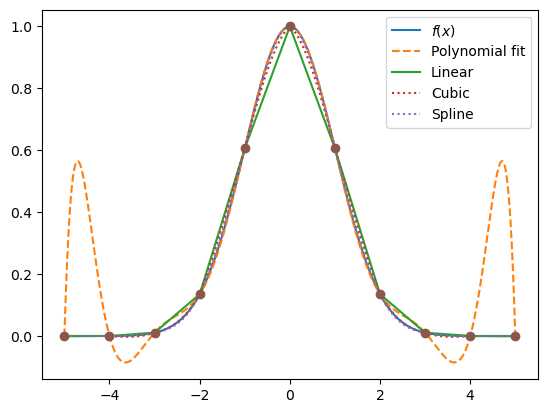

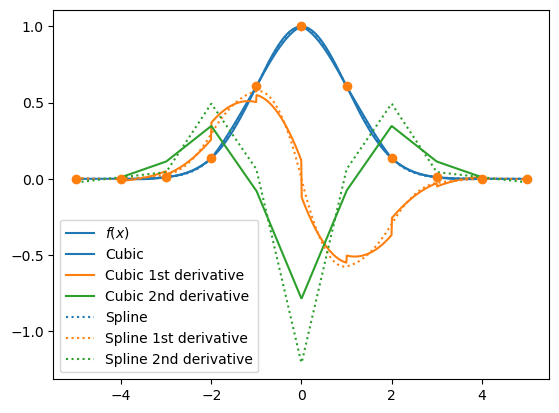

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# function to interpolate
def func_sin(x):
    f = np.sin(x) 
    return f

def func_step(x):
    # step function / discontinuous gradient
    f = np.zeros_like(x)
    for i, xx in enumerate(x):
        if xx>np.pi:
            f[i] = 1.0
        else:
            f[i] = (xx/np.pi)
    return f

def func_exp(x):
    # Gaussian
    return np.exp(-x**2/2)

def func_poly(x):
    # polynomial
    poly = np.polynomial.Polynomial([-10, 3, 0, 0, 0, 0])
    return poly(x)

def cubic_interpolation(x, xp, fp):
    # storage for the interpolated function and derivatives
    f2 = np.zeros_like(x)
    f2d = np.zeros_like(x)
    f2dd = np.zeros_like(x)

    # do a cubic polynomial fit to each interval (except the first and last)
    for i in range(len(xp)-3):
        poly = np.polynomial.Polynomial.fit(xp[i:i+4], fp[i:i+4], 3)    
        ind = np.where(np.logical_and(x<xp[i+2],x>=xp[i+1]))
        f2[ind] = poly(x[ind])
        f2d[ind] = poly.deriv(m=1)(x[ind])
        f2dd[ind] = poly.deriv(m=2)(x[ind])
    
    # exclude the first and last intervals
    ind = np.where(np.logical_and(x>=xp[1],x<xp[-2]))
    f2 = f2[ind]
    f2d = f2d[ind]
    f2dd = f2dd[ind]  
    x2 = x[ind]

    return x2, f2, f2d, f2dd

# choose one of the above functions to fit
func = func_exp
x1 = -5
x2 = 5
n_points = 11    # number of sample points
add_noise = False    # whether to add noise
noise_amp = 0.001  # noise amplitude

# Sample the function
xp = np.linspace(x1, x2, num=n_points)
fp = func(xp)
# add noise
if add_noise:
    fp = fp + noise_amp*np.random.normal(size = len(xp))

# 1. Piecewise linear interpolation
x = np.linspace(x1, x2, num=10**3)
f1 = np.interp(x, xp, fp)

# 2. Cubic interpolation
x2, f2, f2d, f2dd = cubic_interpolation(x, xp, fp)

# 3. Spline
f3 = scipy.interpolate.CubicSpline(xp,fp) #, bc_type = 'natural')

# 4. Lagrange polynomial fit to all points
poly = scipy.interpolate.lagrange(xp, fp)

# Calculate the maximum errors
print('Number of points = %d' %(n_points,))
print('Maximum error for linear is %e' % (np.max(np.abs((f1-func(x))))/np.max(func(x)),)  )
ind = np.where(np.logical_and(x>=xp[1],x<xp[-2]))
print('Maximum error for cubic is %e' % (np.max(np.abs((f2-func(x2))))/np.max(func(x2)),)  )
print('Maximum error for spline is %e' % (np.max(np.abs((f3(x)-func(x))))/np.max(func(x)),)  )
print('Maximum error for poly is %e' % (np.max(np.abs((poly(x)-func(x))))/np.max(func(x)),)  )

# Plot the function and different interpolations
plt.plot(x,func(x), label=r'$f(x)$')
plt.plot(x,poly(x),'--', label='Polynomial fit')
plt.plot(x,f1, label='Linear')
plt.plot(x2,f2,':', label='Cubic')
plt.plot(x,f3(x),':', label='Spline')
plt.plot(xp,fp, 'o')
plt.legend()
plt.show()

# Plot the derivatives
plt.clf()
plt.plot(x, func(x), label=r'$f(x)$')
plt.plot(x2, f2, "C0", label = 'Cubic')
plt.plot(x2, f2d, "C1", label = 'Cubic 1st derivative')
plt.plot(x2, f2dd, "C2", label = 'Cubic 2nd derivative')
plt.plot(x, f3(x), "C0:", label = 'Spline')
plt.plot(x, f3(x,1), "C1:", label = 'Spline 1st derivative')
plt.plot(x, f3(x,2), "C2:", label = 'Spline 2nd derivative')
plt.plot(xp, fp, 'o')
plt.legend()
plt.show()

Things to note:

- For $N$ sample points, the error in linear interpolation decreases as $N^2$, cubic and spline decrease as $N^4$.  This is because the largest correction term (next term in the Taylor expansion) is $\propto (\Delta x)^2$ for linear and $\propto (\Delta x)^4$ for cubic. 
- The full $N-1$-order polynomial fit (Lagrange polynomial) does not behave well, often showing high frequency components, particularly near the boundaries of the domain ([Runge's phenomenon](https://en.wikipedia.org/wiki/Runge's_phenomenon)).
- The cubic fits show discontinities in the derivatives at the sampled points; the spline (by definition) has continuous first and second derivatives.
- The cubic and spline fits develop oscillations near discontinous changes in the function of derivatives. Adding Gaussian noise to the data points also can lead to oscillations in the interpolated function.
- The cubic and spline interpolations are able to fit polynomials up to 3rd order exactly. The Lagrange fit will fit up to order $N-1$ exactly. 